In [15]:
# Import các thư viện cần thiết
import torch
import learn2learn as l2l
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [16]:
# Load dữ liệu
data = pd.read_csv("../../../Dataset/ADBE_Stock.csv")
df=data.reset_index()['Close']

In [17]:
# Chuẩn hóa dữ liệu sử dụng MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

In [18]:
# Chia train test
train_size = int(0.75 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [19]:
# Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [20]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [21]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [22]:
# Tạo DataLoader
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(ytest))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [23]:
# Xây dựng mô hình
class StockPredictor(nn.Module):
    def __init__(self):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [24]:
# Định nghĩa hàm meta-learning
def fast_adapt(batch, learner, loss, adaptation_steps, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)
    for step in range(adaptation_steps):
        predictions = learner(data).view(-1)
        train_loss = loss(predictions, labels.view(-1))
        learner.adapt(train_loss)
    return train_loss

In [25]:
# Định nghĩa quá trình training
def meta_train(maml, train_loader, meta_optimizer, loss, adaptation_steps, meta_batch_size, device):
    for epoch in range(100):
        meta_loss = 0.0
        for batch in train_loader:
            learner = maml.clone()
            batch_loss = fast_adapt(batch, learner, loss, adaptation_steps, device)
            meta_loss += batch_loss.item()
            meta_optimizer.zero_grad()
            batch_loss.backward()
            # Ensure that only leaf tensors are used to calculate the gradients
            for param in maml.parameters():
                if param.grad is not None:
                    param.grad = param.grad.clone().detach()
            meta_optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {meta_loss/len(train_loader)}')

In [26]:
# Khởi tạo mô hình và các thành phần cần thiết
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StockPredictor().to(device)
maml = l2l.algorithms.MAML(model, lr=0.01)
meta_optimizer = optim.Adam(maml.parameters(), lr=0.001)
loss = nn.MSELoss()

In [27]:
# Training mô hình
meta_train(maml, train_loader, meta_optimizer, loss, adaptation_steps=3, meta_batch_size=32, device=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:675: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


Epoch 1, Loss: 0.13838912998991354
Epoch 2, Loss: 0.055650507499064715
Epoch 3, Loss: 0.0373030939538564
Epoch 4, Loss: 0.012751047499477863
Epoch 5, Loss: 0.006626928591036371
Epoch 6, Loss: 0.004429311358502933
Epoch 7, Loss: 0.0035239276975127204
Epoch 8, Loss: 0.0031041477507512483
Epoch 9, Loss: 0.0029444280246804866
Epoch 10, Loss: 0.0028012976150161456
Epoch 11, Loss: 0.00282136320934764
Epoch 12, Loss: 0.0025869403699679033
Epoch 13, Loss: 0.0024867827804493053
Epoch 14, Loss: 0.002447371404351933
Epoch 15, Loss: 0.0022247474657238592
Epoch 16, Loss: 0.0022601772631917682
Epoch 17, Loss: 0.002148148279437529
Epoch 18, Loss: 0.00204132533898311
Epoch 19, Loss: 0.0021346575813367963
Epoch 20, Loss: 0.00209882904476087
Epoch 21, Loss: 0.002006811073182949
Epoch 22, Loss: 0.0019184314047119447
Epoch 23, Loss: 0.0019514921836421958
Epoch 24, Loss: 0.0018432285370571272
Epoch 25, Loss: 0.0017532583276209021
Epoch 26, Loss: 0.0017596145459849919
Epoch 27, Loss: 0.0016665121906303934
E

In [28]:
# Dự đoán và hiển thị kết quả trên tập test
model.eval()
predictions = []
with torch.no_grad():
    for i in range(len(X_test)):
        x = torch.Tensor(X_test[i:i+1]).to(device)
        pred = model(x).cpu().numpy()
        predictions.append(pred)

predictions = np.array(predictions).flatten()
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

In [29]:
# Dự báo 30 ngày tiếp theo
x_input = X_test[-1].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_30 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 30):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_30.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_30_days = scaler.inverse_transform(np.array(lst_output_30).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 30 ngày tiếp theo:")
print(predicted_30_days)


Dự báo 30 ngày tiếp theo:
[[482.94556935]
 [482.62546216]
 [486.22076859]
 [491.76631221]
 [498.36000334]
 [505.54162165]
 [513.06492886]
 [520.79934916]
 [528.68037001]
 [536.68085275]
 [544.79387054]
 [553.02198218]
 [561.37053787]
 [569.84375056]
 [578.4423698 ]
 [587.16282878]
 [595.99649482]
 [604.92982444]
 [613.94457009]
 [623.01803868]
 [632.12366014]
 [641.23140101]
 [650.30833301]
 [659.3192534 ]
 [668.22733112]
 [676.99493387]
 [685.58427426]
 [693.95813353]
 [702.08112802]
 [709.91970915]]


In [30]:
# Dự báo 60 ngày tiếp theo
x_input = X_test[-1].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_60 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 60):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_60_days = scaler.inverse_transform(np.array(lst_output_60).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 60 ngày tiếp theo:")
print(predicted_60_days)


Dự báo 60 ngày tiếp theo:
[[482.94556935]
 [482.62546216]
 [486.22076859]
 [491.76631221]
 [498.36000334]
 [505.54162165]
 [513.06492886]
 [520.79934916]
 [528.68037001]
 [536.68085275]
 [544.79387054]
 [553.02198218]
 [561.37053787]
 [569.84375056]
 [578.4423698 ]
 [587.16282878]
 [595.99649482]
 [604.92982444]
 [613.94457009]
 [623.01803868]
 [632.12366014]
 [641.23140101]
 [650.30833301]
 [659.3192534 ]
 [668.22733112]
 [676.99493387]
 [685.58427426]
 [693.95813353]
 [702.08112802]
 [709.91970915]
 [717.44363668]
 [724.62628884]
 [731.44517932]
 [737.8825258 ]
 [743.92530174]
 [749.56564982]
 [754.80046849]
 [759.63146361]
 [764.06489   ]
 [768.11082773]
 [771.78297539]
 [775.09787464]
 [778.07460009]
 [780.73372545]
 [783.09722013]
 [785.18772554]
 [787.02793479]
 [788.6403859 ]
 [790.04704827]
 [791.26896086]
 [792.32597366]
 [793.23690282]
 [794.01901372]
 [794.68807264]
 [795.25865691]
 [795.74368973]
 [796.15485365]
 [796.50243552]
 [796.79563665]
 [797.04236601]]


In [31]:
# Dự báo 90 ngày tiếp theo
x_input = X_test[-1].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_90 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 90):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_90_days = scaler.inverse_transform(np.array(lst_output_90).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 90 ngày tiếp theo:")
print(predicted_90_days)

Dự báo 90 ngày tiếp theo:
[[482.94556935]
 [482.62546216]
 [486.22076859]
 [491.76631221]
 [498.36000334]
 [505.54162165]
 [513.06492886]
 [520.79934916]
 [528.68037001]
 [536.68085275]
 [544.79387054]
 [553.02198218]
 [561.37053787]
 [569.84375056]
 [578.4423698 ]
 [587.16282878]
 [595.99649482]
 [604.92982444]
 [613.94457009]
 [623.01803868]
 [632.12366014]
 [641.23140101]
 [650.30833301]
 [659.3192534 ]
 [668.22733112]
 [676.99493387]
 [685.58427426]
 [693.95813353]
 [702.08112802]
 [709.91970915]
 [717.44363668]
 [724.62628884]
 [731.44517932]
 [737.8825258 ]
 [743.92530174]
 [749.56564982]
 [754.80046849]
 [759.63146361]
 [764.06489   ]
 [768.11082773]
 [771.78297539]
 [775.09787464]
 [778.07460009]
 [780.73372545]
 [783.09722013]
 [785.18772554]
 [787.02793479]
 [788.6403859 ]
 [790.04704827]
 [791.26896086]
 [792.32597366]
 [793.23690282]
 [794.01901372]
 [794.68807264]
 [795.25865691]
 [795.74368973]
 [796.15485365]
 [796.50243552]
 [796.79563665]
 [797.04236601]
 [797.24960214

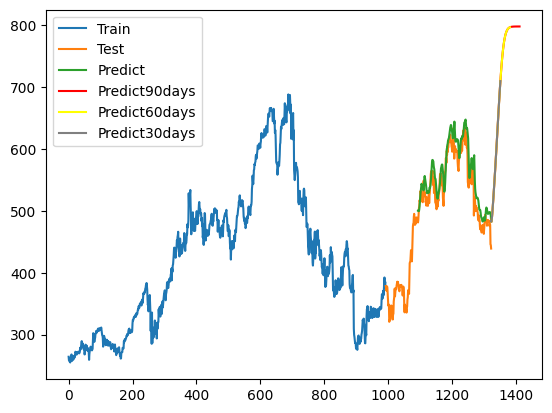

In [32]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(predictions))
predict_data_index_90 = pd.RangeIndex(start=len(df)-1, stop=len(df)+89, step=1)
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
predict_data_index_60 = pd.RangeIndex(start=len(df)-1, stop=len(df)+59, step=1)
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
predict_data_index_30 = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Train','Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.show()

In [33]:
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#  Tính MAE
def calculate_mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

# Tính toán RMSE, MAPE và MDA
test_rmse = np.sqrt(np.mean((predictions - ytest) ** 2))
test_mape = calculate_mape(ytest, predictions)
test_mae = calculate_mae(ytest, predictions)

# In kết quả
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 561.36330282593
Testing MAPE: 85261.22791023203
Testing MAE: 559.325834594492
